# COURSE:   PGP [AI&ML]

## Learner :  Chaitanya Kumar Battula
## Module  : NLP
## Topic   : Build a speech-to-text Model with TensorFlow Dataset

In [0]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [0]:
os.listdir('input/')

['link_to_gcp_credits_form.txt',
 'sample_submission.7z',
 'test',
 'test.7z',
 'train',
 'train.7z']

In [0]:
train_audio_path = 'input/train/audio/'

In [0]:
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)

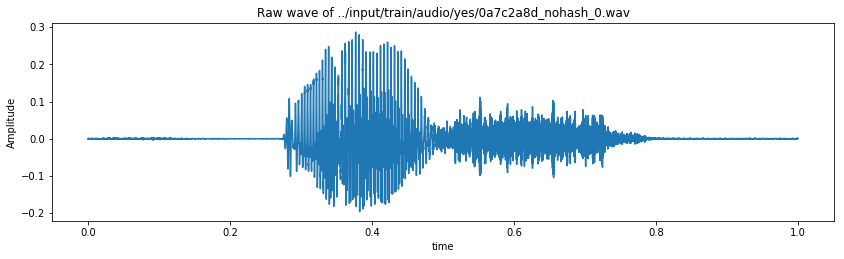

In [0]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [0]:
ipd.Audio(samples, rate=sample_rate)

In [0]:
print(sample_rate)

16000


In [0]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [0]:
labels=os.listdir(train_audio_path)

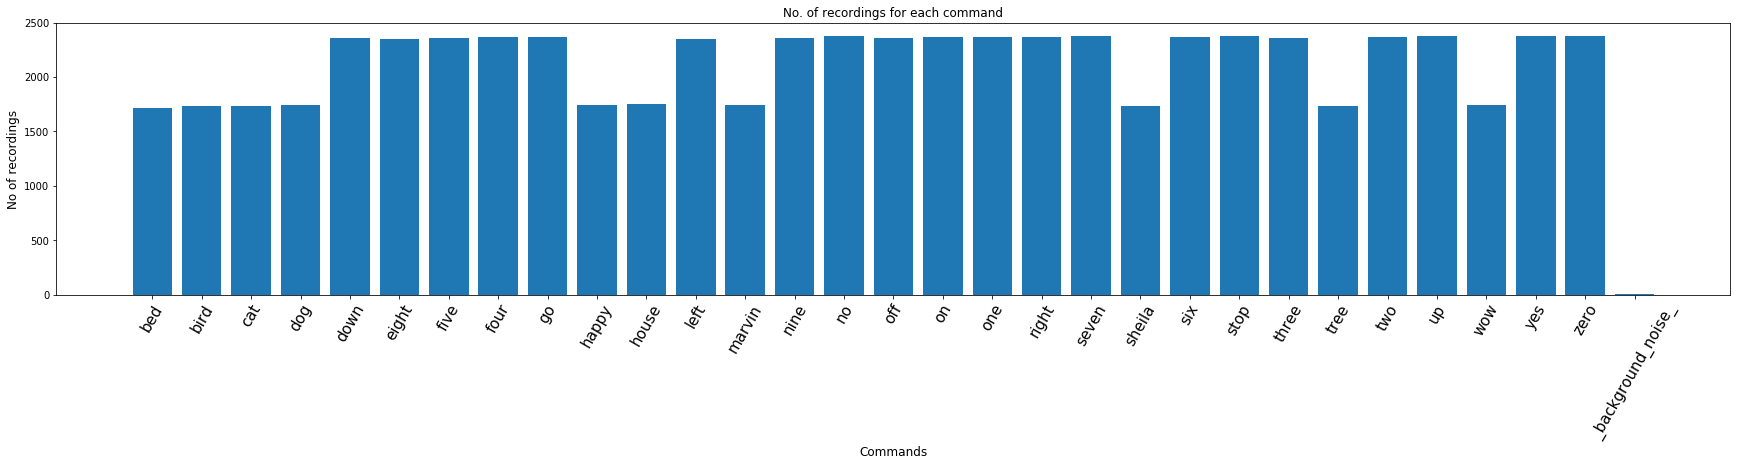

In [0]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [0]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

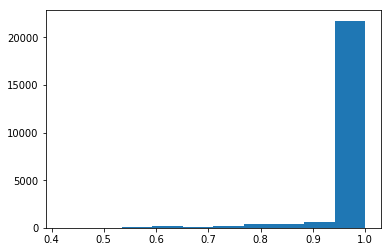

In [0]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [0]:
train_audio_path = 'input/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [0]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [0]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [0]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [0]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as k
k.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
history=model.fit(x_tr, y_tr ,epochs=10, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 17049 samples, validate on 4263 samples
Epoch 1/10
17024/17049 [============================>.] - ETA: 0s - loss: 2.0469 - accuracy: 0.2261

W0102 15:54:13.919300 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 160s 9ms/sample - loss: 2.0462 - accuracy: 0.2263 - val_loss: 1.6518 - val_accuracy: 0.4110
Epoch 2/10
17024/17049 [============================>.] - ETA: 0s - loss: 1.5090 - accuracy: 0.4314

W0102 15:56:47.769280 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 154s 9ms/sample - loss: 1.5087 - accuracy: 0.4315 - val_loss: 1.3245 - val_accuracy: 0.5285
Epoch 3/10
17024/17049 [============================>.] - ETA: 0s - loss: 1.2663 - accuracy: 0.5423

W0102 15:59:21.794144 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 154s 9ms/sample - loss: 1.2665 - accuracy: 0.5422 - val_loss: 1.0714 - val_accuracy: 0.6268
Epoch 4/10
17024/17049 [============================>.] - ETA: 0s - loss: 1.1118 - accuracy: 0.6061

W0102 16:01:54.914526 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 153s 9ms/sample - loss: 1.1117 - accuracy: 0.6062 - val_loss: 0.9686 - val_accuracy: 0.6648
Epoch 5/10
17024/17049 [============================>.] - ETA: 0s - loss: 1.0078 - accuracy: 0.6471

W0102 16:04:27.818031 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 153s 9ms/sample - loss: 1.0080 - accuracy: 0.6470 - val_loss: 0.8611 - val_accuracy: 0.7065
Epoch 6/10
17024/17049 [============================>.] - ETA: 0s - loss: 0.9224 - accuracy: 0.6772

W0102 16:07:01.524079 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 154s 9ms/sample - loss: 0.9222 - accuracy: 0.6773 - val_loss: 0.8575 - val_accuracy: 0.7033
Epoch 7/10
17024/17049 [============================>.] - ETA: 0s - loss: 0.8409 - accuracy: 0.7129

W0102 16:09:38.548263 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 157s 9ms/sample - loss: 0.8407 - accuracy: 0.7131 - val_loss: 0.7111 - val_accuracy: 0.7640
Epoch 8/10
17024/17049 [============================>.] - ETA: 0s - loss: 0.7690 - accuracy: 0.7376

W0102 16:12:23.867259 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 165s 10ms/sample - loss: 0.7694 - accuracy: 0.7374 - val_loss: 0.7176 - val_accuracy: 0.7591
Epoch 9/10
17024/17049 [============================>.] - ETA: 0s - loss: 0.7232 - accuracy: 0.7513

W0102 16:15:16.369312 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 173s 10ms/sample - loss: 0.7227 - accuracy: 0.7514 - val_loss: 0.7066 - val_accuracy: 0.7628
Epoch 10/10
17024/17049 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.7725

W0102 16:18:07.700273 19884 callbacks.py:990] Can save best model only with val_acc available, skipping.


17049/17049 [==============================] - 171s 10ms/sample - loss: 0.6619 - accuracy: 0.7725 - val_loss: 0.6855 - val_accuracy: 0.7708


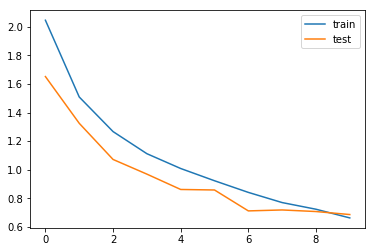

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [0]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

In [0]:
print("Text:",predict(samples))

Text: down


# End Of  Practice Project